In [1]:
import numpy as np
import pandas as pd
from IPython.display import FileLink
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
from torch.optim import lr_scheduler
import torch.utils.data
import torch.utils.data.distributed
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torchvision.utils import make_grid

%matplotlib inline

In [2]:
path = 'data/dogbreeds/'
batch_size = 32
epochs = 5
num_classes = 120

In [3]:
labels = pd.read_csv(path + 'labels.csv')
sample_submission = pd.read_csv(path + 'sample_submission.csv')

In [4]:
all_classes = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).index)
classes = all_classes[:num_classes]
selected_labels = labels[labels['breed'].isin(classes)].reset_index(drop=True)

class_to_num = dict(zip(classes, range(num_classes)))
num_to_class = dict(zip(range(num_classes), classes))
selected_labels['class'] = [class_to_num[breed] for breed in selected_labels['breed'].values]

In [5]:
train_labels = selected_labels.sample(frac=0.7)
valid_labels = selected_labels[~selected_labels['id'].isin(train_labels['id'])]

In [6]:
class DogsDataset(Dataset):
    def __init__(self, root_dir, labels, transform, output_class=True):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
        self.output_class = output_class
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        item = self.labels.iloc[idx]
        path = '{}/{}.jpg'.format(self.root_dir, item['id'])
        image = Image.open(path).convert('RGB')

        if self.transform:
            image = self.transform(image)
            
        if not self.output_class:
            return image
        
        return image, item['class']

In [7]:
def train(model, train, valid, optimizer, criterion, epochs=1):
    for epoch in range(epochs):
        print('Epoch ', epoch + 1, '/', epochs)

        model.train()
        for i, (input, target) in enumerate(train):
            input = input.cuda()
            target = target.cuda()
            input_var = torch.autograd.Variable(input)
            target_var = torch.autograd.Variable(target)

            optimizer.zero_grad()

            # compute output
            output = model(input_var)
            loss = criterion(output, target_var)

            loss.backward()
            optimizer.step()

            print('\r', 'Batch', i, 'Loss', loss.data[0], end='')
            
        total_loss = 0.
        total_batches = 0.

        model.eval()
        for i, (input, target) in enumerate(valid):
            input = input.cuda()
            target = target.cuda()
            input_var = torch.autograd.Variable(input, volatile=True)
            target_var = torch.autograd.Variable(target, volatile=True)

            output = model(input_var)
            loss = criterion(output, target_var)

            total_loss += loss.data[0]
            total_batches += 1.

        loss = total_loss / total_batches
        print()
        print('\r', "Val Loss", loss)

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.pause(0.001)

In [14]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_trans = transforms.Compose([
    transforms.RandomSizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

val_trans = transforms.Compose([
    transforms.Scale(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

In [15]:
train_dataset = DogsDataset(path + 'images', train_labels, train_trans)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

train_dataset_val = DogsDataset(path + 'images', train_labels, val_trans)
train_loader_val = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    DogsDataset(path + 'images', valid_labels, val_trans),
    batch_size=batch_size
)

test_loader = torch.utils.data.DataLoader(
    DogsDataset(path + 'test/x', sample_submission, val_trans, output_class=False),
    batch_size=batch_size
)

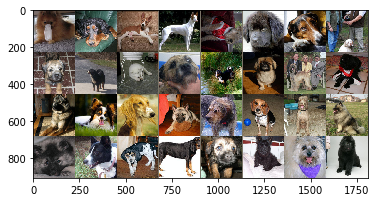

In [11]:
inputs, derp = next(iter(train_loader))
out = make_grid(inputs)
imshow(out)

In [22]:
model = models.densenet161(pretrained=True) #models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, num_classes)
model = model.cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.classifier.parameters())

In [17]:
train(model, train_loader, val_loader, optimizer, criterion, epochs=5)

Epoch  1 / 5
 Batch 223 Loss 1.5634590387344364
 Val Loss 0.9571608634044727
Epoch  2 / 5
 Batch 223 Loss 1.0269980430603027
 Val Loss 0.598358832920591
Epoch  3 / 5
 Batch 223 Loss 1.1485742330551147
 Val Loss 0.5112987194831172
Epoch  4 / 5
 Batch 223 Loss 1.18154859542846686
 Val Loss 0.470797596188883
Epoch  5 / 5
 Batch 223 Loss 0.44105720520019536
 Val Loss 0.47360412031412125


In [18]:
for param in model.parameters():
    param.requires_grad = True
    
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train(model, train_loader, val_loader, optimizer, criterion, epochs=5)

torch.save(model.state_dict(), path + 'weights.torch')

Epoch  1 / 5
 Batch 223 Loss 0.65784782171249395
 Val Loss 0.4241908815068503
Epoch  2 / 5
 Batch 223 Loss 0.92962223291397197
 Val Loss 0.43796974420547485
Epoch  3 / 5
 Batch 223 Loss 0.49904477596282963
 Val Loss 0.422896361288925
Epoch  4 / 5
 Batch 171 Loss 0.34604310989379883

KeyboardInterrupt: 

In [23]:
model.load_state_dict(torch.load(path + 'weights.torch'))
model.eval()
results = []

for i, input in enumerate(test_loader):
    input = input.cuda()
    input_var = torch.autograd.Variable(input, volatile=True)
    output = model(input_var)
    results.append(F.softmax(output).cpu().data.numpy())
    print('\r', 'Batch', i, end='')
    
results = np.concatenate(results)

 Batch 323

In [24]:
ids = sample_submission['id'].values
sdf = pd.DataFrame(ids, columns=['id'])

for index, breed in enumerate(all_classes):
    if index < num_classes:
        sdf[breed] = np.clip(results[:,index], 0.01, 0.99)
    else:
        sdf[breed] = 0.01
    
sdf = sdf.sort_values('id').reset_index(drop=True)
sdf = sdf[['id'] + sorted(all_classes)]
sdf.to_csv('pred.csv', index=None)

FileLink('pred.csv')

/home/bill/pred.csv